<a href="https://colab.research.google.com/github/oskargirardin/CRP_GDPR_datasets/blob/master/use_cases/fraud_detection/article/FD_ARTICLE_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FRAUD DETECTION ARTICLE - SUPPORTING NOTEBOOK - PART 2**

In this notebook, you will find the code that generates the results showcased in the article **"FILL IN ARTICLE NAME"** (LINK TO THE ARTICLE TO BE INSERTED) by SIA Partners in collaboration with students from Essec & Centrale Supélec.

The first part is dedicated to the ***generation of the synthetic samples***, while the second on is dedicated to ***benchmarking the performance*** of the models trained on the different versions of the dataset. 

In order to run the notebook requires the following resources: 

*   Kaggle json file to download the dataset
*   The `generator.py` and the `SimilairtyCheck.py` files 


The two Python files and their documentation can be found in the following GitHub repository: add link 

For any questions or remarks, please contact xx@xx.com.link text

## Importing libraries and data

In [ ]:
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

In [ ]:
#Not run unless issues with Numpy
!pip uninstall numpy
!pip install numpy

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
from generator import *
from augmentation import *
from generator_augment import *

from SimilarityCheck import *

In [ ]:
#We are using a dataset from kaggle. Don't forget to load a kaggle.json file before running this cell
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d incarnyx/car-insurance-fraud

  0% 0.00/1.82M [00:00<?, ?B/s]
100% 1.82M/1.82M [00:00<00:00, 143MB/s]


In [6]:
!unzip car-insurance-fraud.zip

Archive:  car-insurance-fraud.zip
  inflating: Dataset.xlsx            


## Loading the data

Note: in order to use our generator, we need to make sure that the data type is constant within the different columns

In [19]:
df = pd.read_excel("Dataset.xlsx")
pd.set_option('display.max_columns', None)

In [27]:
cat_col = []

for col in list(df):
  if df[col].dtypes == 'object':
    cat_cols.append(col)

In [ ]:
#Checking for datatype consistency across the columns
for col in df.columns:
    unique_types = df[col].apply(type).unique()
    if len(unique_types) > 1:
        print(col, unique_types)

DayOfWeekClaimed [<class 'str'> <class 'int'>]
MonthClaimed [<class 'str'> <class 'int'>]
PastNumberOfClaims [<class 'str'> <class 'int'>]


In [23]:
#In this dataset three variables with mixed datatype - we set them all to object type
df['PastNumberOfClaims'] = df['PastNumberOfClaims'].astype("string").astype('object')
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].astype("string").astype('object')
df['MonthClaimed'] = df['MonthClaimed'].astype("string").astype('object')

## Splitting the dataframe into train and validation


In [24]:
data, validation = train_test_split(df, test_size = 0.3, random_state = 42)

## Synthetic samples generation
In the following section we will have the objective of generating two augmented datasets.

The first one is will be simply ***augmented***. That means that we will:


1.   Take the `data` dataset and extract the minority class
2.   Create a synthetic sample similar to the minority class
3.   Merge the generated sample with the original dataset to form an *augmented set*.

The second one will be both a ***synthetic*** and ***augmented*** version of the `data` dataset. To obtain it we will:

1.   Take the `data` dataset and separate the majority and the minority class
2.   Create two synthetic samples. One similar to the majority class, the other to the minority class
3.   Merge the two generated samples  to form a *synthetized and augmented set*.


It should be noted that we developed two funtions: `augmentation` and `generator_augmentation` that do all of this automatically. The reason we are showing all the passages in this notebook is that we want to be able to perform similarity checks on the generated samples, and that would not be possible to do with the final outputs of these functions. 

To have a better understanding of how to implement our functions please refer to the following GitHub repository:
[link to repository](https://)



### Splitting the dataframe into fraud and non-fraud

In [25]:
fraud_df = data[data['FraudFound_P'] ==1].drop('FraudFound_P',axis=1)
no_fraud_df = data[data['FraudFound_P'] ==0].drop('FraudFound_P',axis=1)

The classes (fraud and no fraud are unbalanced). Our goal now is to synthesize both fraud and non-fraud data, but generate additional samples for the fraud data to augment the dataset and rebalance the classes. 

In [54]:
print(len(fraud_df))
print(len(no_fraud_df))

484
7611


### Generating the synthetic samples for augmentation

Our objective here is to augment the minority class so that its final size is approximately 30% of the majority class. That is: 

`size minority class + generated sample = size majority class * 0.3`

In [55]:
generator_fraud_aug = Generator(num_epochs=3, n_samples=1750, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df,
                          categorical_columns=cat_col)

synth_fraud_aug = generator_fraud_aug.generate()

Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.003827
std       0.011426
min      -0.016561
25%      -0.003692
50%       0.001582
75%       0.010865
max       0.037447
dtype: float64
Sensitivity threshold: 0.024746835443037952 qt_max: 0.05


Map:   0%|          | 0/484 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


  0%|          | 0/237 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.024746835443037952,                         val_sensitivity: -0.005309423347398033,                             val_sensitivities: [0.003691983122362868, -0.012341772151898736, -0.008122362869198313, 0.00031645569620252986, -0.0064345991561181445, -0.008122362869198313, -0.0005274261603375544, -0.0064345991561181445, 0.0028481012658227826, 0.013818565400843879, -0.014873417721518989, -0.023312236286919835, -0.009810126582278483, -0.006434599156118145, -0.0039029535864978913]


  0%|          | 0/1750 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1792 samples generated. Sampling efficiency is: 100.0000%


### Generating the synthetic samples for augmentation and synthetization

In [56]:
generator_no_fraud = Generator(num_epochs=3, n_samples=7500, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=no_fraud_df,
                          categorical_columns=cat_col)

generator_fraud = Generator(num_epochs=3, n_samples=2250, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df,
                          categorical_columns=cat_col)

synth_no_fraud = generator_no_fraud.generate()
synth_fraud = generator_fraud.generate()

Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 62...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.000390
std       0.003796
min      -0.007437
25%      -0.001659
50%       0.000118
75%       0.002469
max       0.009900
dtype: float64
Sensitivity threshold: 0.007251767125048194 qt_max: 0.05


Map:   0%|          | 0/7611 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,1.413100
200,1.015600
300,0.981000
400,0.961700
500,0.950000
600,0.939800
700,0.937800


  0%|          | 0/3765 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.007251767125048194,                         val_sensitivity: 0.002561667309257593,                             val_sensitivities: [0.0036184295077753507, 0.0004106156021076984, 0.0021121963757871737, -0.005837938568307416, -0.004084950520498651, 0.005122092276057062, 0.0005802596067343529, 0.004489782804266803, 0.009255237116051923, 0.003001542218223879, 0.009964657499036115, 0.0029192905796170156, -0.0020055262819688984, 0.004885618815062331, 0.003993702608919162]


  0%|          | 0/7500 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 7552 samples generated. Sampling efficiency is: 99.9868%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.003827
std       0.011426
min      -0.016561
25%      -0.003692
50%       0.001582
75%       0.010865
max       0.037447
dtype: float64
Sensitivity threshold: 0.024746835443037952 qt_max: 0.05


Map:   0%|          | 0/484 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


  0%|          | 0/237 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.024746835443037952,                         val_sensitivity: -0.005309423347398033,                             val_sensitivities: [0.003691983122362868, -0.012341772151898736, -0.008122362869198313, 0.00031645569620252986, -0.0064345991561181445, -0.008122362869198313, -0.0005274261603375544, -0.0064345991561181445, 0.0028481012658227826, 0.013818565400843879, -0.014873417721518989, -0.023312236286919835, -0.009810126582278483, -0.006434599156118145, -0.0039029535864978913]


  0%|          | 0/2250 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 2304 samples generated. Sampling efficiency is: 100.0000%


### Checking the similarities

In [31]:
#AUGMENTATION SAMPLE
similarity_checker_fraud_aug = SimilarityCheck(generator_fraud_aug.data, synth_fraud_aug, cat_col, generator_fraud_aug.metadata)
similarity_checker_fraud_aug.comparison_columns()

Creating report: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]



Overall Quality Score: 91.04%

Properties:
Column Shapes: 93.75%
Column Pair Trends: 88.33%
                  Column        Metric  Quality Score
0            WeekOfMonth  KSComplement       0.945381
1     WeekOfMonthClaimed  KSComplement       0.947625
2                    Age  KSComplement       0.932321
3           PolicyNumber  KSComplement       0.877577
4              RepNumber  KSComplement       0.928876
5             Deductible  KSComplement       0.939115
6           DriverRating  KSComplement       0.992746
7                   Year  KSComplement       0.963672
8              ClaimSize  KSComplement       0.860656
9                  Month  TVComplement       0.930281
10             DayOfWeek  TVComplement       0.916139
11                  Make  TVComplement       0.879081
12          AccidentArea  TVComplement       0.951240
13      DayOfWeekClaimed  TVComplement       0.942411
14          MonthClaimed  TVComplement       0.875216
15                   Sex  TVComplement     

In [30]:
#AUGMENTATION + SYNTHETIZATION SAMPLE
similarity_checker_nofraud = SimilarityCheck(generator_no_fraud.data, synth_no_fraud, cat_col, generator_no_fraud.metadata)
similarity_checker_fraud = SimilarityCheck(generator_fraud.data, synth_fraud, cat_col, generator_fraud.metadata)

similarity_checker_nofraud.comparison_columns()
similarity_checker_fraud.comparison_columns()


Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]



Overall Quality Score: 97.37%

Properties:
Column Shapes: 98.14%
Column Pair Trends: 96.61%
                  Column        Metric  Quality Score
0            WeekOfMonth  KSComplement       0.970010
1     WeekOfMonthClaimed  KSComplement       0.984010
2                    Age  KSComplement       0.976556
3           PolicyNumber  KSComplement       0.972773
4              RepNumber  KSComplement       0.971296
5             Deductible  KSComplement       0.993711
6           DriverRating  KSComplement       0.989873
7                   Year  KSComplement       0.975387
8              ClaimSize  KSComplement       0.974207
9                  Month  TVComplement       0.965665
10             DayOfWeek  TVComplement       0.979952
11                  Make  TVComplement       0.979740
12          AccidentArea  TVComplement       0.989101
13      DayOfWeekClaimed  TVComplement       0.985410
14          MonthClaimed  TVComplement       0.971576
15                   Sex  TVComplement     

Creating report: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]



Overall Quality Score: 90.97%

Properties:
Column Shapes: 93.67%
Column Pair Trends: 88.27%
                  Column        Metric  Quality Score
0            WeekOfMonth  KSComplement       0.937254
1     WeekOfMonthClaimed  KSComplement       0.951770
2                    Age  KSComplement       0.932435
3           PolicyNumber  KSComplement       0.877043
4              RepNumber  KSComplement       0.934209
5             Deductible  KSComplement       0.941019
6           DriverRating  KSComplement       0.992937
7                   Year  KSComplement       0.966173
8              ClaimSize  KSComplement       0.859831
9                  Month  TVComplement       0.928349
10             DayOfWeek  TVComplement       0.917236
11                  Make  TVComplement       0.869431
12          AccidentArea  TVComplement       0.951240
13      DayOfWeekClaimed  TVComplement       0.939998
14          MonthClaimed  TVComplement       0.879089
15                   Sex  TVComplement     

### Concatenate synthetic dataset

In [32]:
synth_no_fraud['FraudFound_P'] = 0
synth_fraud['FraudFound_P'] = 1
synth_fraud_aug['FraudFound_P'] = 1

#fully synthetic dataset
synth = pd.concat([synth_no_fraud,synth_fraud],ignore_index=True, axis = 0)
synth = synth.sample(frac=1).reset_index(drop=True)

#augmented dataset
aug_df = pd.concat([synth_fraud_aug,data],ignore_index=True, axis = 0)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

## Data preprocessing 
Now that we have created the desired augmented datasets, we preprocess the data so that it can be fit for modeling

### Preprocessing support functions

In [33]:
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df.astype('int32')], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)

In [34]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
          }
months_proc = lambda x: months.get(x, 0)

D_o_w = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
          }
D_o_w_proc = lambda x: D_o_w.get(x, 0)

vehicle_prices = {
    'less than 20000': 1,
    '20000 to 29000' : 2,
    '30000 to 39000' : 3,
    '40000 to 59000' : 4,
    '60000 to 69000' : 5,
    'more than 69000': 6,
          }
vehicle_price_proc = lambda x: vehicle_prices.get(x, 0)


AgeOfVehicle_variants = {
    'new'         : 0.5,
    '2 years'     : 2,
    '3 years'     : 3,
    '4 years'     : 4,
    '5 years'     : 5,
    '6 years'     : 6,
    '7 years'     : 7,
    'more than 7' : 8.5,
          }
vehicle_age_proc = lambda x: AgeOfVehicle_variants[x]

age_variants = {
    '16 to 17'     : 1,
    '18 to 20'     : 2,
    '21 to 25'     : 3,
    '26 to 30'     : 4,
    '31 to 35'     : 5,
    '36 to 40'     : 6,
    '41 to 50'     : 7,
    '51 to 65'     : 8,
    'over 65'      : 9,
          }
age_proc = lambda x: age_variants[x]



def preprocess(data):
  data = data.dropna(axis = 0)
  data = data[data['Age'] > 0.0]
  data['Month'] = data['Month'].apply(months_proc)
  data['MonthClaimed'] = data['MonthClaimed'].apply(months_proc)
  data['DayOfWeek'] = data['DayOfWeek'].apply(D_o_w_proc)
  data['DayOfWeekClaimed'] = data['DayOfWeekClaimed'].apply(D_o_w_proc)
  data['VehiclePrice'] = data['VehiclePrice'].apply(vehicle_price_proc)
  data['AgeOfVehicle'] = data['AgeOfVehicle'].apply(vehicle_age_proc)
  data['AgeOfPolicyHolder'] = data['AgeOfPolicyHolder'].apply(age_proc)
  data = dummies(data)
  return data



### Preprocessing 

In [35]:
#preprocess real data
df_p = preprocess(data)

#preprocess validation data
validation_p = preprocess(validation)

#preprocess augmented data
aug_df_p = preprocess(aug_df)

#preprocess fake data
synth_p = preprocess(synth)

***Note***: since we carried out preprocessing (in particular one-hot encoding) after we split the `data` and `validation` sets, we have to now make sure that all the datasets we are considering for our evaluation have the same shape. 

In [36]:
for col in list(df_p):
  if col not in list(validation_p):
    validation_p[col] = 0
  if col not in list(synth_p):
    synth_p[col] = 0

In [37]:
for col in list(validation_p):
  if col not in list(df_p):
    df_p[col] = 0
  if col not in list(synth_p):
    synth_p[col] = 0
  if col not in list(aug_df_p):
    aug_df_p[col] = 0

In [38]:
validation_p = validation_p[list(df_p)]
synth_p = synth_p[list(df_p)]
aug_df_p = aug_df_p[list(df_p)]

In [39]:
print(df_p.shape)
print(validation_p.shape)
print(aug_df_p.shape)
print(synth_p.shape)

(7898, 76)
(3403, 76)
(9637, 76)
(9440, 76)


## Modeling

In the following section we will train various models on the different training datasets (original, augmented and augmented + synthetized), and will compare their perfomance by testing them with the same validation set. 

### Results evaluation function

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def eval_result(model, X_test, y_test, validation = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # model predictions
        pred = model.predict(X_test)

        # classification method & confusion matrix
        print("\n", classification_report(y_test, pred, target_names = ['Not Fraud', 'Fraud']), "\n")

        display(pd.DataFrame(confusion_matrix(y_test, pred), 
                         columns = ['Predicted Not Fraud', 'Predicted Fraud'],
                         index = ['Not Fraud', 'Fraud']))
        
        print("\n")

        # feature importance
        if hasattr(model, 'feature_importances_') and not validation:
            features = pd.DataFrame({
                'Variable'  :X_test.columns,
                'Importance':model.feature_importances_
            })

            features.sort_values('Importance', ascending=False, inplace=True)
            display(features.head(20))

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()

### Original Data

#### XGBoost: AUC = 0.779


               precision    recall  f1-score   support

   Not Fraud       0.98      0.97      0.97      3210
       Fraud       0.52      0.59      0.55       193

    accuracy                           0.95      3403
   macro avg       0.75      0.78      0.76      3403
weighted avg       0.95      0.95      0.95      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3104,106
Fraud,79,114


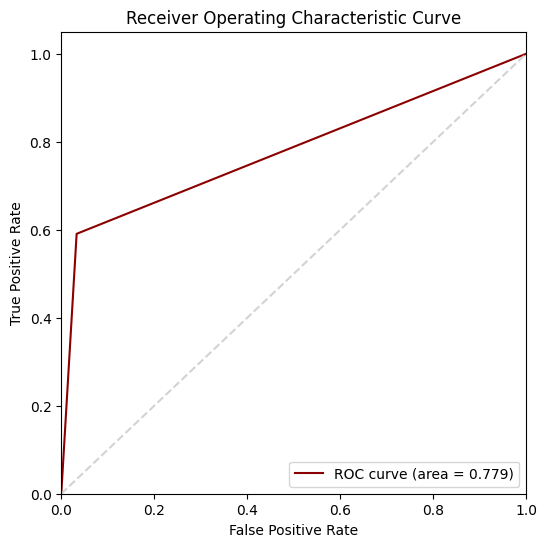

In [47]:
xgbr = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr.fit(df_p.drop("FraudFound_P", axis = 1), df_p["FraudFound_P"])
eval_result(xgbr, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)

#### Random Forest: AUC = 0.50


               precision    recall  f1-score   support

   Not Fraud       0.94      1.00      0.97      3210
       Fraud       0.00      0.00      0.00       193

    accuracy                           0.94      3403
   macro avg       0.47      0.50      0.49      3403
weighted avg       0.89      0.94      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3210,0
Fraud,193,0


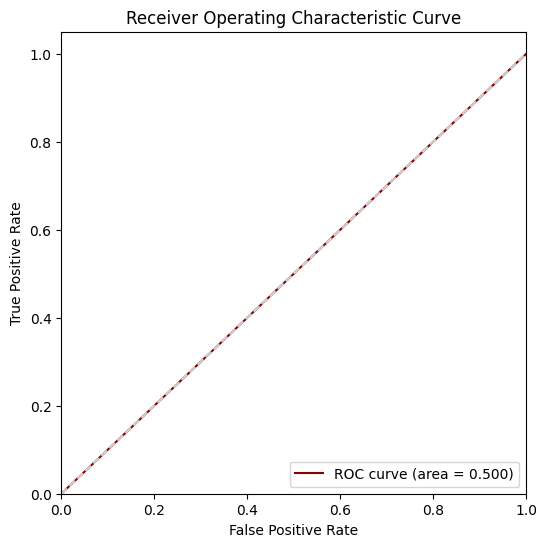

In [50]:
rf1 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

rf1.fit(df_p.drop("FraudFound_P", axis = 1), df_p["FraudFound_P"])
eval_result(rf1, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)

### Augmented data

#### XGBoost: AUC = 0.80


               precision    recall  f1-score   support

   Not Fraud       0.98      0.92      0.95      3210
       Fraud       0.33      0.68      0.45       193

    accuracy                           0.90      3403
   macro avg       0.65      0.80      0.70      3403
weighted avg       0.94      0.90      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2942,268
Fraud,61,132


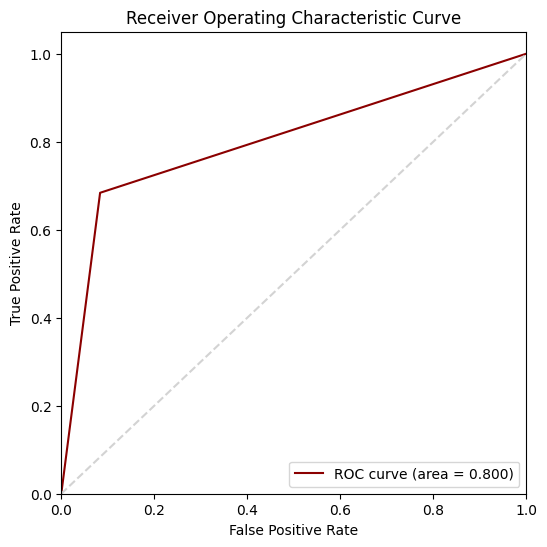

In [48]:
xgbr2 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr2.fit(aug_df_p.drop("FraudFound_P", axis = 1), aug_df_p["FraudFound_P"])
eval_result(xgbr2, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)

#### Random Forest: AUC = 0.511


               precision    recall  f1-score   support

   Not Fraud       0.94      1.00      0.97      3210
       Fraud       0.31      0.03      0.05       193

    accuracy                           0.94      3403
   macro avg       0.63      0.51      0.51      3403
weighted avg       0.91      0.94      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3199,11
Fraud,188,5


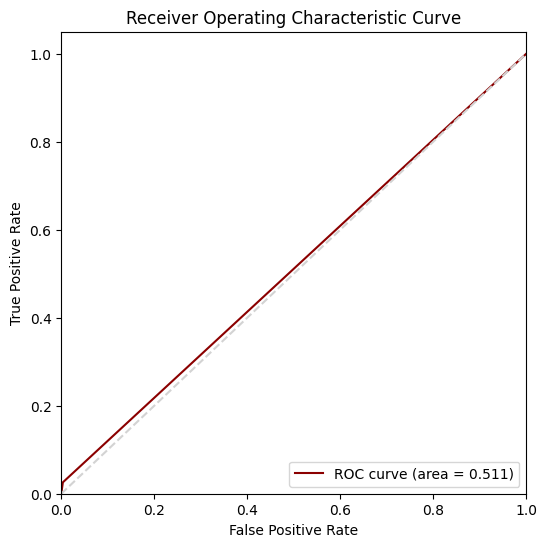

In [51]:
rf2 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

rf2.fit(aug_df_p.drop("FraudFound_P", axis = 1), aug_df_p["FraudFound_P"])
eval_result(rf2, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)

### Augmented and synthetized data

#### XGBoost: AUC = 0.53


               precision    recall  f1-score   support

   Not Fraud       0.95      0.98      0.96      3210
       Fraud       0.20      0.09      0.12       193

    accuracy                           0.93      3403
   macro avg       0.57      0.53      0.54      3403
weighted avg       0.90      0.93      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3143,67
Fraud,176,17


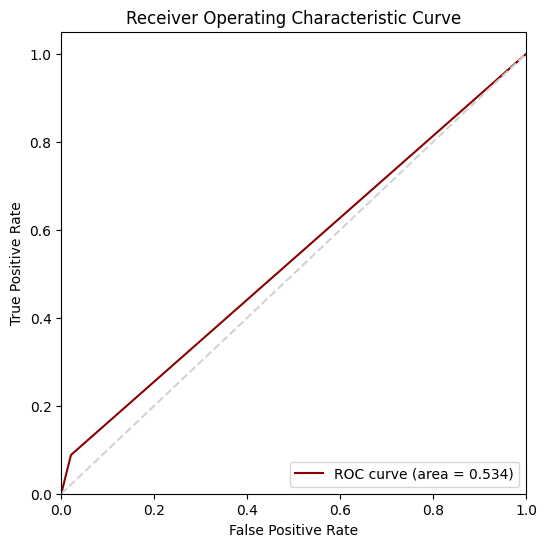

In [49]:
xgbr3 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr3.fit(synth_p.drop("FraudFound_P", axis = 1), synth_p["FraudFound_P"])
eval_result(xgbr3, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)

#### Random Forest: AUC = 0.510


               precision    recall  f1-score   support

   Not Fraud       0.94      0.99      0.97      3210
       Fraud       0.23      0.03      0.05       193

    accuracy                           0.94      3403
   macro avg       0.59      0.51      0.51      3403
weighted avg       0.90      0.94      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3193,17
Fraud,188,5


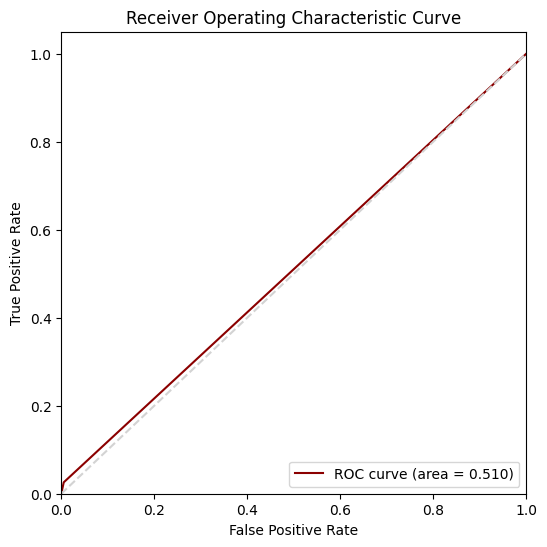

In [53]:
clf3 = RandomForestClassifier(criterion='gini', max_depth = 10, n_estimators= 100)

clf3.fit(synth_p.drop("FraudFound_P", axis = 1), synth_p["FraudFound_P"])
eval_result(clf3, validation_p.drop("FraudFound_P", axis = 1), validation_p["FraudFound_P"],validation= True)